In [1]:
import argparse
import operator
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from functools import reduce
from operator import mul


## Optimizee Modules:

In [2]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(28 * 28, 32)
        self.linear2 = nn.Linear(32, 10)

    def forward(self, inputs):
        x = inputs.view(-1, 28 * 28)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return F.log_softmax(x)

# CIFAR10 classifier with 2 lienar layers - should be fast but not amazing
class Model_CIFAR10(nn.Module):

    def __init__(self):
        super(Model_CIFAR10, self).__init__()
        self.linear1 = nn.Linear(32 * 32, 50)
        self.linear2 = nn.Linear(50, 10)

    def forward(self, inputs):
        x = inputs.view(-1, 32 * 32 )
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return F.log_softmax(x,dim=1)


 # CIFAR10 classifier with CNN - TO DO
class Model_CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(Model_CIFAR10_CNN, self).__init__()
        # self.norm1  = nn.BatchNorm2d(num_features = 3)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)

        # self.norm2  = nn.BatchNorm2d(num_features = 6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)


##Optmizers: 
 First some useful functions and after the correct optmizer class

In [3]:
def get_batch(batch_size):
    x = torch.randn(batch_size, 10)
    x = x - 2 * x.pow(2)
    y = x.sum(1)
    return x, y

def preprocess_gradients(x):
    p = 10
    eps = 1e-6
    indicator = (x.abs() > math.exp(-p)).float()
    x1 = (x.abs() + eps).log() / p * indicator - (1 - indicator)
    x2 = x.sign() * indicator + math.exp(p) * x * (1 - indicator)

    return torch.cat((x1.view(-1,1), x2.view(-1,1)), -1)


In [4]:
class MetaOptimizer(nn.Module):

    def __init__(self, model, num_layers, hidden_size):
        super(MetaOptimizer, self).__init__()
        self.meta_model = model

        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(3, hidden_size)
        self.ln1 = LayerNorm1D(hidden_size)

        self.lstms = []
        for i in range(num_layers):
            self.lstms.append(LayerNormLSTMCell(hidden_size, hidden_size))

        self.linear2 = nn.Linear(hidden_size, 1)
        self.linear2.weight.data.mul_(0.1)
        self.linear2.bias.data.fill_(0.0)

    def cuda(self):
        super(MetaOptimizer, self).cuda()
        for i in range(len(self.lstms)):
            self.lstms[i].cuda()

    def reset_lstm(self, keep_states=False, model=None, use_cuda=False):
        self.meta_model.reset()
        self.meta_model.copy_params_from(model)

        if keep_states:
            for i in range(len(self.lstms)):
                self.hx[i] = Variable(self.hx[i].data)
                self.cx[i] = Variable(self.cx[i].data)
        else:
            self.hx = []
            self.cx = []
            for i in range(len(self.lstms)):
                self.hx.append(Variable(torch.zeros(1, self.hidden_size)))
                self.cx.append(Variable(torch.zeros(1, self.hidden_size)))
                if use_cuda:
                    self.hx[i], self.cx[i] = self.hx[i].cuda(), self.cx[i].cuda()

    def forward(self, x):
        # Gradients preprocessing
        x = torch.tanh(self.ln1(self.linear1(x)))

        for i in range(len(self.lstms)):
            if x.size(0) != self.hx[i].size(0):
                self.hx[i] = self.hx[i].expand(x.size(0), self.hx[i].size(1))
                self.cx[i] = self.cx[i].expand(x.size(0), self.cx[i].size(1))

            self.hx[i], self.cx[i] = self.lstms[i](x, (self.hx[i], self.cx[i]))
            x = self.hx[i]

        x = self.linear2(x)
        return x.squeeze()

    def meta_update(self, model_with_grads, loss):
        # First we need to create a flat version of parameters and gradients
        grads = []

        for module in model_with_grads.children():
          try:
            grads.append(module._parameters['weight'].grad.data.view(-1))
            grads.append(module._parameters['bias'].grad.data.view(-1))
          except:
            pass

        flat_params = self.meta_model.get_flat_params()
        flat_grads = preprocess_gradients(torch.cat(grads))   # Pre-processing does not work...
        # flat_grads =  torch.cat(grads)

        # torch.cat((x1.view(-1,1), x2.view(-1,1)), -1)
        inputs = Variable(torch.cat((flat_grads, flat_params.data.unsqueeze(1)), -1))

        # Meta update itself
        flat_params = flat_params + self(inputs)

        self.meta_model.set_flat_params(flat_params)

        # Finally, copy values from the meta model to the normal one.
        self.meta_model.copy_params_to(model_with_grads)
        return self.meta_model.model

class FastMetaOptimizer(nn.Module):

    def __init__(self, model, num_layers, hidden_size):
        super(FastMetaOptimizer, self).__init__()
        self.meta_model = model

        self.linear1 = nn.Linear(6, 2)
        self.linear1.bias.data[0] = 1

    def forward(self, x):
        # Gradients preprocessing
        x = torch.sigmoid(self.linear1(x))
        return x.split(1, 1)

    def reset_lstm(self, keep_states=False, model=None, use_cuda=False):
        self.meta_model.reset()
        self.meta_model.copy_params_from(model)

        if keep_states:
            self.f = Variable(self.f.data)
            self.i = Variable(self.i.data)
        else:
            self.f = Variable(torch.zeros(1, 1))
            self.i = Variable(torch.zeros(1, 1))
            if use_cuda:
                self.f = self.f.cuda()
                self.i = self.i.cuda()

    def meta_update(self, model_with_grads, loss):
        # First we need to create a flat version of parameters and gradients
        grads = []

        for module in model_with_grads.children():
            grads.append(module._parameters['weight'].grad.data.view(-1).unsqueeze(-1))
            grads.append(module._parameters['bias'].grad.data.view(-1).unsqueeze(-1))

        flat_params = self.meta_model.get_flat_params().unsqueeze(-1)
        flat_grads = torch.cat(grads)

        self.i = self.i.expand(flat_params.size(0), 1)
        self.f = self.f.expand(flat_params.size(0), 1)

        loss = loss.expand_as(flat_grads)
        inputs = Variable(torch.cat((preprocess_gradients(flat_grads), flat_params.data, loss), 1))
        inputs = torch.cat((inputs, self.f, self.i), 1)
        self.f, self.i = self(inputs)

        # Meta update itself
        flat_params = self.f * flat_params - self.i * Variable(flat_grads)
        flat_params = flat_params.view(-1)

        self.meta_model.set_flat_params(flat_params)

        # Finally, copy values from the meta model to the normal one.
        self.meta_model.copy_params_to(model_with_grads)
        return self.meta_model.model

# A helper class that keeps track of meta updates
# It's done by replacing parameters with variables and applying updates to
# them.


class MetaModel:

    def __init__(self, model):
        self.model = model

    def reset(self):
        for module in self.model.children():
          try:
              module._parameters['weight'] = Variable(module._parameters['weight'].data)
              module._parameters['bias'] = Variable(module._parameters['bias'].data)
          except:
              pass
    def get_flat_params(self):
        params = []
        for module in self.model.children():
            try:
              params.append(module._parameters['weight'].view(-1))
              params.append(module._parameters['bias'].view(-1))
            except:
              pass

        return torch.cat(params)

    def set_flat_params(self, flat_params):
        # Restore original shapes
        offset = 0
        for i, module in enumerate(self.model.children()):
            try:
              weight_shape = module._parameters['weight'].size()
              bias_shape = module._parameters['bias'].size()

              weight_flat_size = reduce(mul, weight_shape, 1)
              bias_flat_size = reduce(mul, bias_shape, 1)

              module._parameters['weight'] = flat_params[
                  offset:offset + weight_flat_size].view(*weight_shape)
              module._parameters['bias'] = flat_params[
                  offset + weight_flat_size:offset + weight_flat_size + bias_flat_size].view(*bias_shape)

              offset += weight_flat_size + bias_flat_size
            except:
              pass

    def copy_params_from(self, model):
        for modelA, modelB in zip(self.model.parameters(), model.parameters()):
            modelA.data.copy_(modelB.data)

    def copy_params_to(self, model):
        for modelA, modelB in zip(self.model.parameters(), model.parameters()):
            modelB.data.copy_(modelA.data)


#  Two supporting classes
class LayerNormLSTMCell(nn.Module):

    def __init__(self, num_inputs, num_hidden, forget_gate_bias=-1):
        super(LayerNormLSTMCell, self).__init__()

        self.forget_gate_bias = forget_gate_bias
        self.num_hidden = num_hidden
        self.fc_i2h = nn.Linear(num_inputs, 4 * num_hidden)
        self.fc_h2h = nn.Linear(num_hidden, 4 * num_hidden)

        self.ln_i2h = LayerNorm1D(4 * num_hidden)
        self.ln_h2h = LayerNorm1D(4 * num_hidden)

        self.ln_h2o = LayerNorm1D(num_hidden)

    def forward(self, inputs, state):
        hx, cx = state
        i2h = self.fc_i2h(inputs)
        h2h = self.fc_h2h(hx)
        x = self.ln_i2h(i2h) + self.ln_h2h(h2h)
        gates = x.split(self.num_hidden, 1)

        in_gate = torch.sigmoid(gates[0])
        forget_gate = torch.sigmoid(gates[1] + self.forget_gate_bias)
        out_gate = torch.sigmoid(gates[2])
        in_transform = F.tanh(gates[3])

        cx = forget_gate * cx + in_gate * in_transform
        hx = out_gate * F.tanh(self.ln_h2o(cx))
        return hx, cx



class LayerNorm1D(nn.Module):

    def __init__(self, num_outputs, eps=1e-5, affine=True):
        super(LayerNorm1D, self).__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(1, num_outputs))
        self.bias = nn.Parameter(torch.zeros(1, num_outputs))

    def forward(self, inputs):
        input_mean = inputs.mean(1,keepdim=True).expand_as(inputs)
        input_std = inputs.std(1,keepdim=True).expand_as(inputs)
        x = (inputs - input_mean) / (input_std + self.eps)
        return x * self.weight.expand_as(x) + self.bias.expand_as(x)


Parse arguments:

In [5]:
parser = argparse.ArgumentParser(description='PyTorch REINFORCE example')

parser.add_argument('-f')
parser.add_argument('--batch_size', type=int, default=512, metavar='N',
                    help='batch size (default: 32)')
parser.add_argument('--optimizer_steps', type=int, default=100, metavar='N',
                    help='number of meta optimizer steps (default: 100)')
parser.add_argument('--truncated_bptt_step', type=int, default=20, metavar='N',
                    help='step at which it truncates bptt (default: 20)')
parser.add_argument('--updates_per_epoch', type=int, default=10, metavar='N',
                    help='updates per epoch (default: 100)')
parser.add_argument('--max_epoch', type=int, default=100, metavar='N',
                    help='number of epoch (default: 10000)')
parser.add_argument('--hidden_size', type=int, default=20, metavar='N',
                    help='hidden size of the meta optimizer (default: 10)')
parser.add_argument('--num_layers', type=int, default=2, metavar='N',
                    help='number of LSTM layers (default: 2)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()


assert args.optimizer_steps % args.truncated_bptt_step == 0

kwargs = {'num_workers': 0, 'pin_memory': True} if args.cuda else {}


Now let's donwload, split and visualise the data:

In [6]:
#CIFAR10 data - grayscale:
# train_loader = torch.utils.data.DataLoader(
#     datasets.CIFAR10('./data', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Grayscale(num_output_channels=1)
#                    ])),
#     batch_size=args.batch_size, shuffle=True, **kwargs)

# test_loader = torch.utils.data.DataLoader(
#     datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
#                        transforms.ToTensor(),
#                         transforms.Grayscale(num_output_channels=1)
#                    ])),
#     batch_size=args.batch_size, shuffle=True, **kwargs)
DATA_FOLDER = "../../dl-datasets/data"
   #CIFAR10 data - coloured:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(DATA_FOLDER, train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(DATA_FOLDER, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

How does the data look like?

Number of batches 98
 ship  ship plane   car


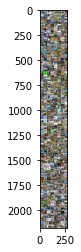

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

print("Number of batches " + str(len(train_loader)))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:

# Create a meta optimizer that wraps a model into a meta model
# to keep track of the meta updates.
meta_model = Model_CIFAR10_CNN()
if args.cuda:
    meta_model.cuda()

meta_optimizer = MetaOptimizer(MetaModel(meta_model), args.num_layers, args.hidden_size)
if args.cuda:
    meta_optimizer.cuda()

optimizer = optim.Adam(meta_optimizer.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size =30 , gamma = 0.5)

for epoch in range(args.max_epoch):
    decrease_in_loss = 0.0
    final_loss = 0.0
    train_iter = iter(train_loader)

    for i in range(args.updates_per_epoch):

        # Sample a new model
        model = Model_CIFAR10_CNN()
        if args.cuda:
            model.cuda()
        
        x, y = next(train_iter)

        if args.cuda:
            x, y = x.cuda(), y.cuda()
        x, y = Variable(x), Variable(y)

        # Compute initial loss of the model
        f_x = model(x)
        initial_loss = F.nll_loss(f_x, y)
        
        for k in range(args.optimizer_steps // args.truncated_bptt_step):
            # Keep states for truncated BPTT
            meta_optimizer.reset_lstm(
                keep_states=k > 0, model=model, use_cuda=args.cuda)

            loss_sum = 0
            prev_loss = torch.zeros(1)
            if args.cuda:
                prev_loss = prev_loss.cuda()

            for j in range(args.truncated_bptt_step):

                # x, y = next(train_iter)

                if args.cuda:
                    x, y = x.cuda(), y.cuda()
                x, y = Variable(x), Variable(y)

                # First we need to compute the gradients of the model
                f_x = model(x)
                loss = F.nll_loss(f_x, y)
                
                model.zero_grad()
                loss.backward()

                # Perfom a meta update using gradients from model
                # and return the current meta model saved in the optimizer
                meta_model = meta_optimizer.meta_update(model, loss.data)

                # Compute a loss for a step the meta optimizer
                f_x = meta_model(x)
                loss = F.nll_loss(f_x, y)

                loss_sum += (loss - Variable(prev_loss))

                prev_loss = loss.data

            # Update the parameters of the meta optimizer
            meta_optimizer.zero_grad()
            loss_sum.backward()
            for param in meta_optimizer.parameters():
                param.grad.data.clamp_(-1, 1)
            optimizer.step()

        # Compute relative decrease in the loss function w.r.t initial
        # value
        
        scheduler.step()    # decay learnign rate
        decrease_in_loss += loss.data.item() / initial_loss.data.item()
        final_loss += loss.data.item()

    print("Epoch: {}, final loss {}, average final/initial loss ratio: {}".format(epoch, final_loss / args.updates_per_epoch,
                                                                    decrease_in_loss / args.updates_per_epoch))



C:\Users\evandertoorn\Anaconda3\envs\ml-1\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:

# torch.save(meta_optimizer.state_dict(),'model_CIFAR10.pt')

In [ ]:
import torchsummary

torchsummary.summary((3,32,32),meta_optimizer)